# *Brain Tumor Classification Project - Resnet50*

## 1. Import Library

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

2025-10-22 10:02:39.697226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761127359.901088      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761127359.963045      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Loading

In [2]:
# Data Labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=224

for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [3]:
X_train.shape

(7023, 224, 224, 3)

## 3. Shuffle & split data (70%-10%-20%) 

In [4]:
from sklearn.model_selection import train_test_split

# Bước 1: shuffle & chia Train+Val (80%) và Test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    stratify=Y_train,
    random_state=42, 
    shuffle=True
)

print("Train & Val:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)

Train & Val: (5618, 224, 224, 3) (5618,)
Test: (1405, 224, 224, 3) (1405,)


In [5]:
# Bước 2: chia Train (70%) và Validation (10%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train,
    test_size=0.125,   
    stratify=Y_train,
    random_state=42,
    shuffle=True
)

# Kiểm tra kích thước
print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: (4915, 224, 224, 3) (4915,)
Validation: (703, 224, 224, 3) (703,)
Test: (1405, 224, 224, 3) (1405,)


In [6]:
# Kiểm tra dtype
print("Train:", X_train.dtype, Y_train.dtype)
print("Validation:", X_val.dtype, Y_val.dtype)
print("Test:", X_test.dtype, Y_test.dtype)

Train: float64 int64
Validation: float64 int64
Test: float64 int64


## 4. Data preprocessing

### 4.1 Data standardization

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

In [8]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [9]:
print("Min pixel:", X_train.min())
print("Max pixel:", X_train.max())

Min pixel: 0.0
Max pixel: 1.0


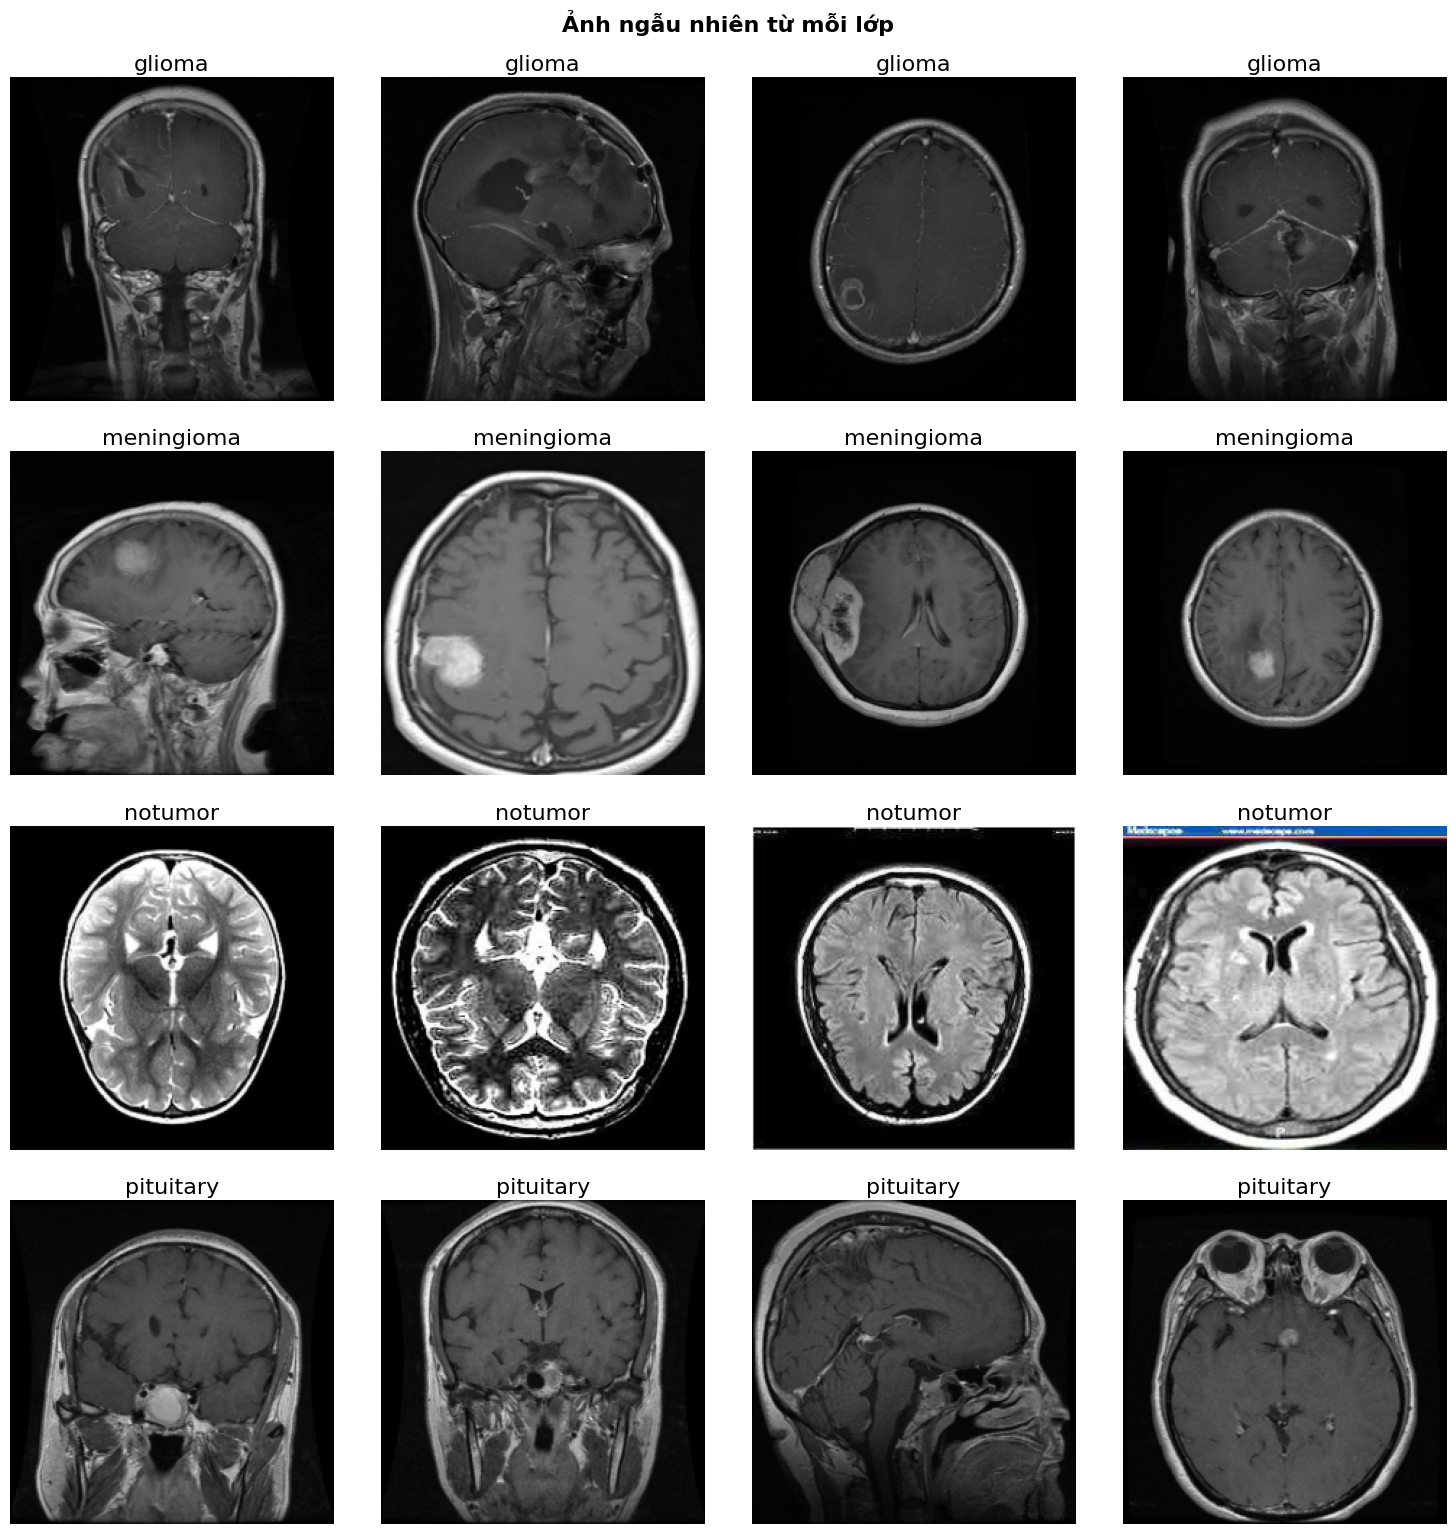

In [10]:
num_samples = 4  # số ảnh mỗi lớp
plt.figure(figsize=(15, 15))

for class_idx, label in enumerate(labels):
    # Lấy index ảnh thuộc lớp này
    idxs = np.where(Y_train == class_idx)[0]
    # Chọn ngẫu nhiên
    sample_idxs = np.random.choice(idxs, num_samples, replace=False)

    for i, idx in enumerate(sample_idxs):
        plt.subplot(len(labels), num_samples, class_idx * num_samples + i + 1)
        plt.imshow(X_train[idx])
        plt.axis("off")
        plt.title(label, fontsize=16, pad=5)

plt.tight_layout(h_pad=2.0)
plt.suptitle("Ảnh ngẫu nhiên từ mỗi lớp", fontsize=16, fontweight="bold", y=1.02)
plt.show()

### 4.2 Data augmentation with generator

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(x * 255.0),
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=None,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(x * 255.0)
)
test_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(x * 255.0)
)

BATCH_SIZE = 32

train_generator = train_datagen.flow(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, Y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow(
    X_test, Y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### 4.4 Show Generator

In [12]:
X_batch, Y_batch = next(train_generator)
print("Image shape:", X_batch.shape)
print("Min pixel:", X_batch.min())
print("Max pixel:", X_batch.max())

Image shape: (32, 224, 224, 3)
Min pixel: -123.68
Max pixel: 151.061


## 5. Train Data with Resnet50

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall

In [14]:
# -------------------------
# class weights 
# -------------------------
y_train = Y_train 
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(k): float(v) for k, v in zip(classes, class_weights)}
print("class_weights:", class_weights)

# -------------------------
# Build model (base + head)
# -------------------------
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# build head with L2 + dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

# -------------------------
# callbacks
# -------------------------
callbacks = [
    ModelCheckpoint('resnet50v2.h5', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# freeze backbone
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

# Fit 
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights,  
    verbose=1
)

class_weights: {0: 1.0825991189427313, 1: 1.0675499565595135, 2: 0.8776785714285714, 3: 0.9997965825874695}


I0000 00:00:1761127597.093226      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761127597.093982      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 24,060,164 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1761127611.749975      67 service.cc:148] XLA service 0x7f32c404f780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761127611.751375      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761127611.751400      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761127613.551483      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/154 ━━━━━━━━━━━━━━━━━━━━ 46:52 18s/step - accuracy: 0.2500 - loss: 3.1277

I0000 00:00:1761127619.553098      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6225 - loss: 1.5216
Epoch 1: val_loss improved from inf to 0.74465, saving model to resnet50v2.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 88s 452ms/step - accuracy: 0.6230 - loss: 1.5194 - val_accuracy: 0.8777 - val_loss: 0.7446 - learning_rate: 0.0010
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8013 - loss: 0.8818
Epoch 2: val_loss improved from 0.74465 to 0.66137, saving model to resnet50v2.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - accuracy: 0.8013 - loss: 0.8817 - val_accuracy: 0.8805 - val_loss: 0.6614 - learning_rate: 0.0010
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8269 - loss: 0.7664
Epoch 3: val_loss improved from 0.66137 to 0.57501, saving model to resnet50v2.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 54s 352ms/step - accuracy: 0.8269 - loss: 0.7665 - val_accuracy: 0.8933 - val_loss: 0.5750 - learning_rate: 0.0010
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8407 

## 6. Evaluation & Report

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

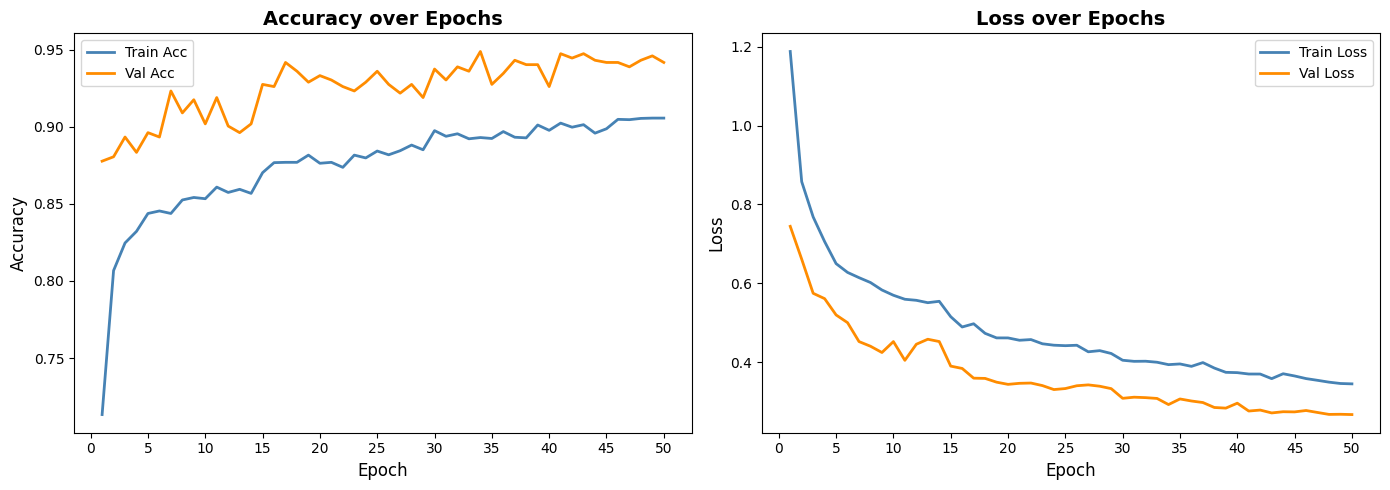

In [16]:
epochs = len(history.history['accuracy'])
epoch_range = range(1, epochs + 1)

plt.figure(figsize=(14,5))

# --- Biểu đồ Accuracy ---
plt.subplot(1,2,1)
plt.plot(epoch_range, history.history['accuracy'], label='Train Acc', color='steelblue', linewidth=2)
plt.plot(epoch_range, history.history['val_accuracy'], label='Val Acc', color='darkorange', linewidth=2)
plt.title('Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.xticks(np.arange(0, epochs+1, max(1, epochs//10)))

# --- Biểu đồ Loss ---
plt.subplot(1,2,2)
plt.plot(epoch_range, history.history['loss'], label='Train Loss', color='steelblue', linewidth=2)
plt.plot(epoch_range, history.history['val_loss'], label='Val Loss', color='darkorange', linewidth=2)
plt.title('Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.xticks(np.arange(0, epochs+1, max(1, epochs//10)))

plt.tight_layout()
plt.show()


In [17]:
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy (from model.evaluate): {acc*100:.2f}%\n")

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.9217 - loss: 0.2780

 Test Accuracy (from model.evaluate): 92.95%



In [18]:
# Dự đoán trên test 
model.load_weights('resnet50v2.h5')
y_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# lấy true labels 
y_true = Y_test

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred,    average='weighted')
f1  = f1_score(y_true, y_pred,        average='weighted')

print(f"\n Test Accuracy: {acc*100:.2f}%\n")
print(f"\n Test Precision: {precision*100:.2f}%\n")
print(f"\n Test Recall: {recall*100:.2f}%\n")
print(f"\n Test F1-score: {f1*100:.2f}%\n")

print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step

 Test Accuracy: 92.95%


 Test Precision: 92.94%


 Test Recall: 92.95%


 Test F1-score: 92.93%

              precision    recall  f1-score   support

      glioma       0.92      0.91      0.92       324
  meningioma       0.86      0.84      0.85       329
     notumor       0.99      0.98      0.99       400
   pituitary       0.92      0.97      0.95       352

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405



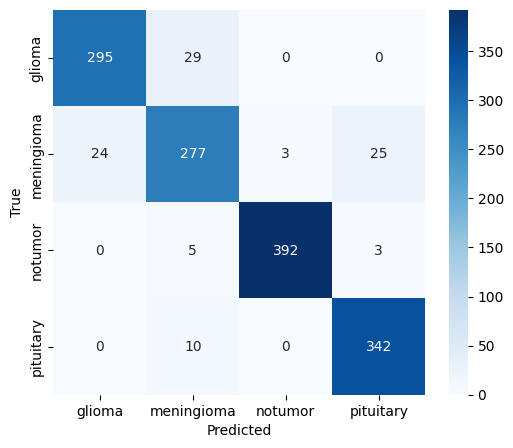

In [19]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

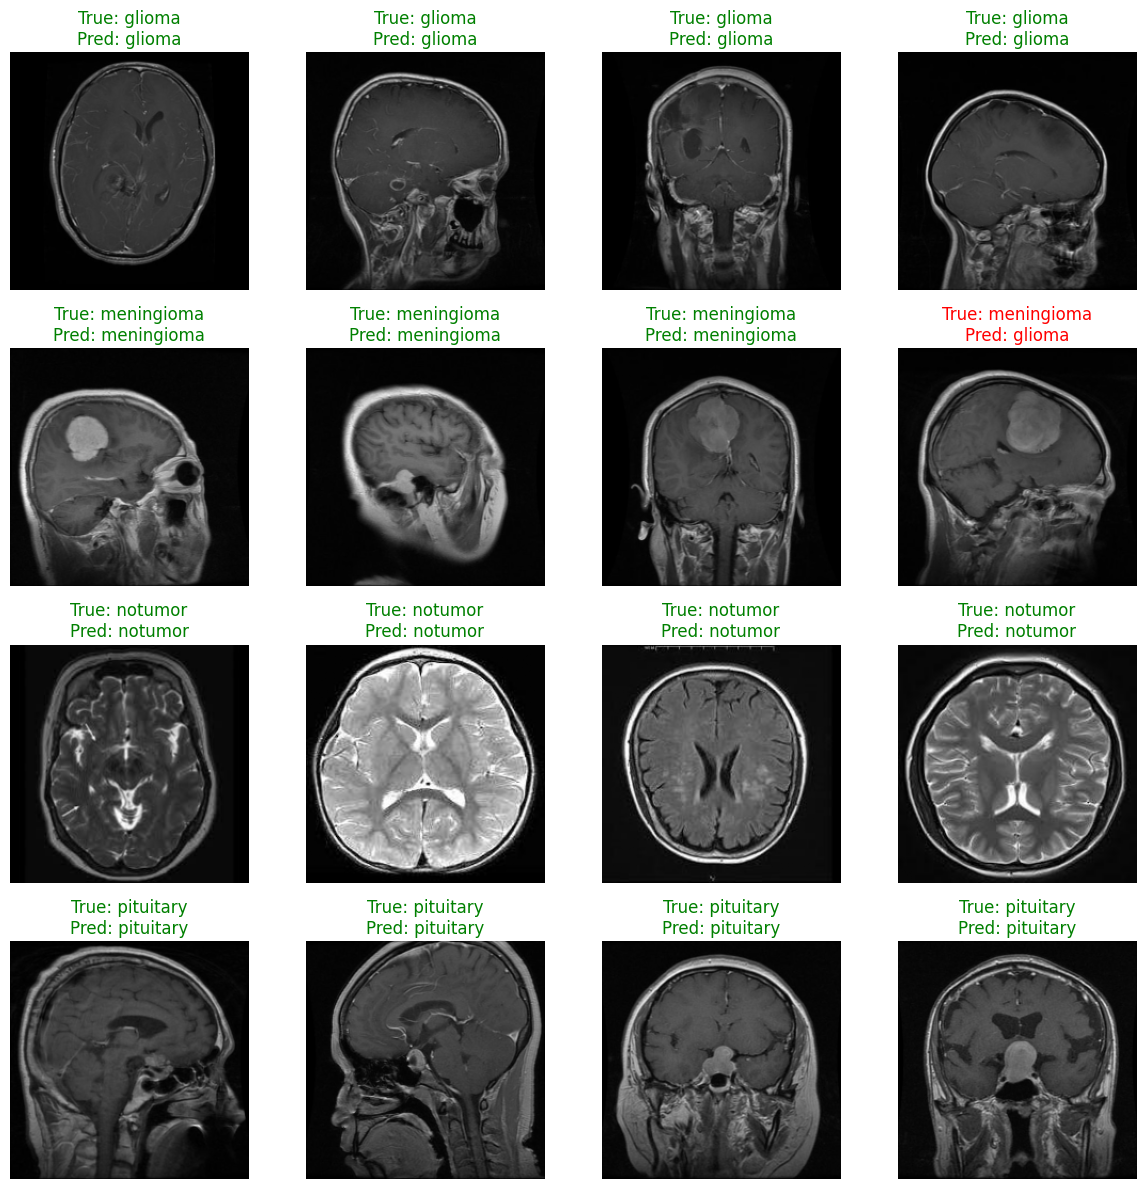

In [20]:
NUM_CLASSES = len(labels)
samples_per_class = 4  

X_test_array = X_test  
y_true_array = y_true
y_pred_array = y_pred

# Tạo dictionary để lưu ảnh theo lớp
imgs_by_class = {cls_idx: [] for cls_idx in range(NUM_CLASSES)}

for idx, (img, true_label, pred_label) in enumerate(zip(X_test_array, y_true_array, y_pred_array)):
    if len(imgs_by_class[true_label]) < samples_per_class:
        imgs_by_class[true_label].append((img, true_label, pred_label))
    # nếu tất cả lớp đều đủ ảnh thì dừng
    if all(len(v) >= samples_per_class for v in imgs_by_class.values()):
        break

# Vẽ hình ảnh
plt.figure(figsize=(samples_per_class * 3, NUM_CLASSES * 3))
plot_idx = 1
for cls_idx in range(NUM_CLASSES):
    for (img, t, p) in imgs_by_class[cls_idx]:
        plt.subplot(NUM_CLASSES, samples_per_class, plot_idx)
        plt.imshow(img[..., 0] if img.shape[-1]==1 else img) 
        title_color = 'green' if t == p else 'red'
        plt.title(f"True: {labels[t]}\nPred: {labels[p]}", color=title_color)
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()
